# Project Milestone 2 : _Donald Trump’s Influence on the Covid Infodemic: An Assessment of a Leader’s Impact on (Mis)information Spread_

---
## Context


Donald Trump’s many tweets during the Covid pandemic spread like wildfire, probably making him one of the most
influential figures during the pandemic – but in the end, was he that influential? Will causal analyses of the effect of
Trump’s tweets on Wikipedia and Google Trends pageviews show that he was leading or following online trends? Our
goal is to study the impact an influential leader can have on information spread in a
crisis with a focus on fake news, as an overload of misleading or contradictory
statements (an infodemic, as [WHO](https://www.who.int/health-topics/infodemic#tab=tab_1) calls it) are known to have a detrimental impact on crisis
management. To provide a more comprehensive insight into Trump’s actual influence
on online information spread, we would then like to compare it with that of other
factors such as mobility restrictions or key milestones (e.g. first Covid death). Trump
the Trend Maker or Trump the Follower, that is the question!


## Imports :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact

# Local Modules
from wiki_pageviews_covid.analyses.helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from wiki_pageviews_covid.analyses.helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from wiki_pageviews_covid.analyses.helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff
from wiki_pageviews_covid.analyses.helpers.pca import get_attention_shift_ts 
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

from wiki_gtrend_visualization import load_wikipedia_df, load_gtrend_df

---
## Part 1: Causal Impact Analysis of Trump's Tweets on Wikipedia Pageviews

### A) We start by preparing and familiarizing with our data

Our datasets :
- Covid dataset from ada class
- Donald Trump's tweet between 2019 and
  2021: [Kaggle](https://www.kaggle.com/datasets/codebreaker619/donald-trump-tweets-dataset)
- List of known fake news and their Google trends'
  reference : [GitHub](https://github.com/epfl-dlab/fact-checkers-fact-check/blob/main/data/kg_ids.json)
- Data extracted from Google Trends and Wikipedia (will be done after)

Let's present the Donald Trump's tweets dataset 

In [2]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)

/var/folders/g4/t17nc9bs2zqcfjn9vq_f93b80000gn/T/ipykernel_30768/286679866.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)


This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [3]:
df.sample(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
22919,324861720487149570,"""""""@MeWonderful2: @realDonaldTrump @Rockinar @...",f,f,Twitter for Android,6,14,2013-04-18,f
39830,785293229390454784,.@HillaryClinton is NOT above the law!#Debates...,f,f,Twitter Web Client,41476,21989,2016-10-10,f
30478,452431310876065794,"""""""@RivalofElmBlock: @TMZ mark cuban is a nut....",f,f,Twitter for Android,164,97,2014-04-05,f
11379,1302559362771292160,Steve Jobs would not be happy that his wife is...,f,f,Twitter for iPhone,87612,24893,2020-09-06,f
32818,659919160340803585,Loved doing the debate last night on @CNBC. Ch...,f,f,Twitter for Android,2901,1127,2015-10-30,f


There is no empty row in the dataset :

In [4]:
print('Number of rows with Nan value is', len(df)-(~df.isna()).prod(axis= 1).sum())

Number of rows with Nan value is 0


Let's focus on covid period:

In [5]:
df_covid = df[df['date'] >= '2019-12-01']
df_covid.sort_values(by='date')
df_covid.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17,f


Check if Donald Trump Tweeted every day :

In [6]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')

print('Number of days where he did not tweet ' , data['id'].isna().sum())

Number of days where he did not tweet  1


Since there is only one day where he didn't tweet, we can drop this day from our dataset, it won't affect our analysis.

In [7]:
data.dropna(inplace=True)

data['per_day_tweets']= data.groupby('date')['date'].transform('count')
data['per_day_retweets']= data.groupby('date')['retweets'].transform('sum')
data['per_day_likes']= data.groupby('date')['favorites'].transform('sum')

We can have a look at the temporal evolutions of Trump's tweets :

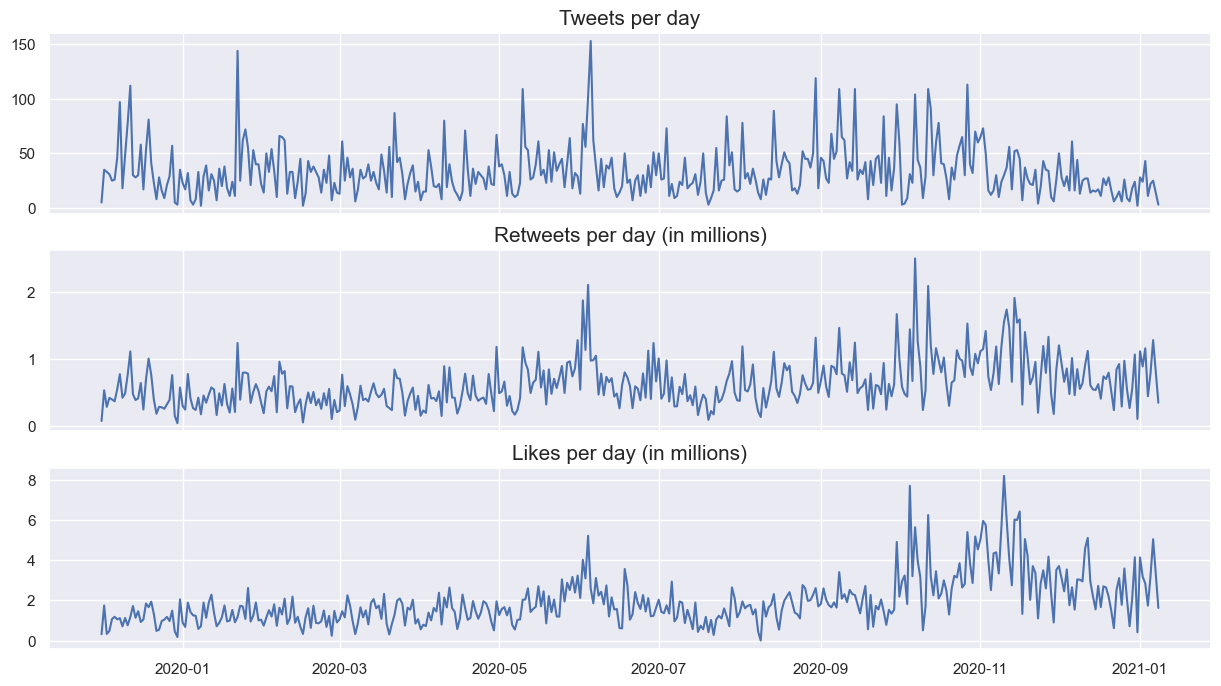

In [8]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False)

axes[0].plot(data['date'], data['per_day_tweets'])
axes[0].set_title('Tweets per day', size=15)
axes[1].plot(data['date'], data['per_day_retweets']/10**6)
axes[1].set_title('Retweets per day (in millions)', size=15)
axes[2].plot(data['date'], data['per_day_likes']/10**6)
axes[2].set_title('Likes per day (in millions)', size=15)

plt.show()

Let's have an idea of the type of tweets we have :

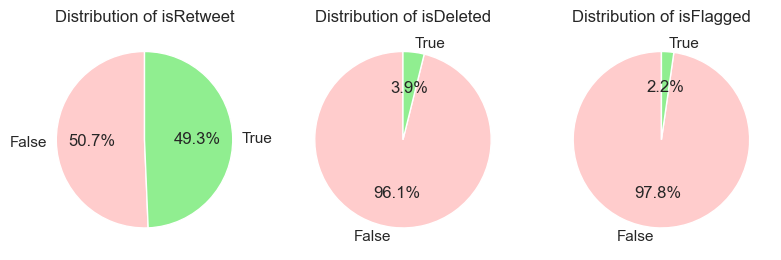

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8, 12))

variables = ['isRetweet', 'isDeleted', 'isFlagged']
colors = ['#FFCCCC', 'lightgreen']

for i, var in enumerate(variables):
    ax = axes[i]
    ax.pie(data[var].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()


There are very few deleted tweets, though this can be an indication of misinformation spreaded by trump.

**Let's focus on covid topics:**

Use spacy to get rid of stop words in the tweets. Stop words are all that words such as and, or, that, etc. that are not relevant for a tweet but are used very often.

In [10]:
#Before running following command install dictionary with:
#python -m spacy download en_core_web_sm

#download a english dictionary to make anlysis
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


In [11]:
#all tweets in one string
result_text = ' '.join(data['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])

#the text we have is too big to process it at once, so we split it into chunks
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

#manually clean text from links, punctuation, etc.
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)#remove links
clean= clean.translate(str.maketrans('', '', string.punctuation))#remove punctuation
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

Let's have a look at the most used words in Trump's tweets :

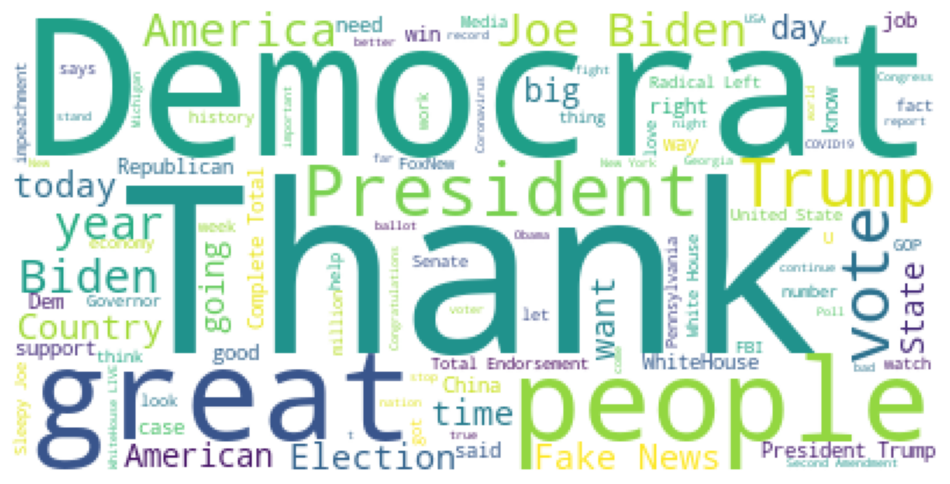

In [12]:
wordcloud = WordCloud(background_color="white").generate(clean)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

As we can see, there are not that much related to covid. Though one can already spot some of his favorite topics.

Let's focus our analysis on covid related tweets

In [13]:
#create a list of words related to covid
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
data['covid_related'] = data['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

data['covid_related'].value_counts()

covid_related
False    12874
True       644
Name: count, dtype: int64

In [14]:
#data where covid_related is true
data_covid_rel = data[data['covid_related']==1]

Following the same process, we can have a look at the most used words in Trump's Covid related tweets :

In [15]:
#all tweets in one string
result_text = ' '.join(data_covid_rel['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])

#the text we have is too big to process it at once, so we split it into chunks
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

#manually clean text from links, punctuation, etc.
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)#remove links
clean= clean.translate(str.maketrans('', '', string.punctuation))#remove punctuation
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

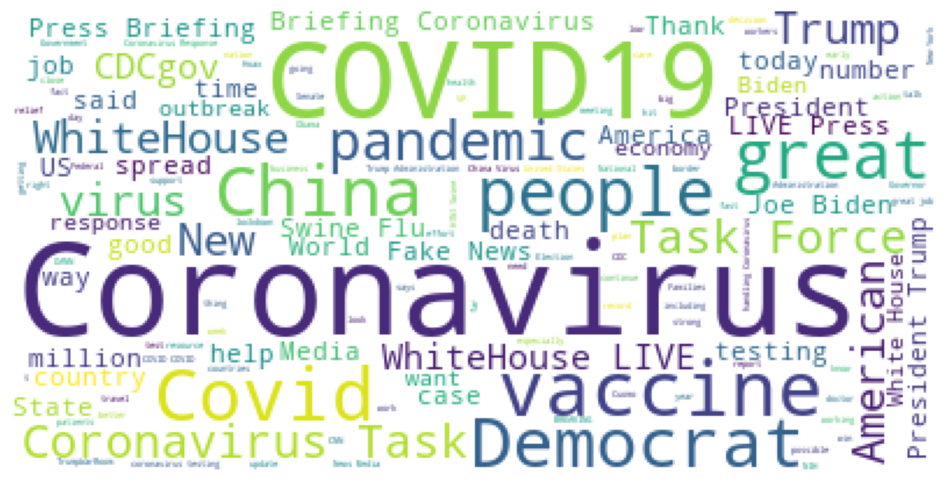

In [16]:
wordcloud = WordCloud(background_color="white").generate(clean)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This image shows a more spreaded distribution of words. Though, one can spot the importance of china, vaccine or even swine flu in his tweets. Lots of words were also related to actions such as Task Force, Live Press or Briefing.

Let's find the moment when Trump tweeted the most about Covid:

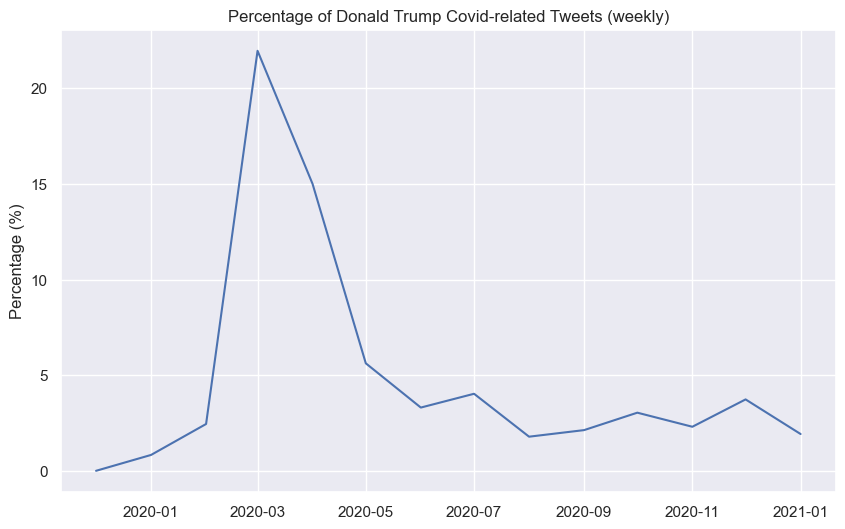

In [17]:
data['month_date'] = data.date.apply(lambda x: x.month)
data['year_date'] = data.date.apply(lambda x: x.year)
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: x.covid_related.sum() / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

#plot the percentage of covid related tweets
plt.figure(figsize=(10, 6)) 
plt.ylabel('Percentage (%)')
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets (weekly)')
plt.show()

As we can see the highest density of covid related tweets is in March 2020, which is the beginning of the pandemic in the US. In March the percentage peaked at 20%. We can also see that the density of covid related tweets is decreasing over time.

Now let's discover if among the most retweeted and the most liked tweets there are some that are related to covid:

In [18]:
data['decile_retweeted'] = pd.qcut(data['retweets'], 10, labels=False, duplicates='drop')
data['decile_favorites'] = pd.qcut(data['favorites'], 10, labels=False, duplicates='drop')

Not all tweets have the same impact on public opinion, hence we want to see in which period covid related tweets were among the most relevant, to adress importance we use retweet as a proxy.

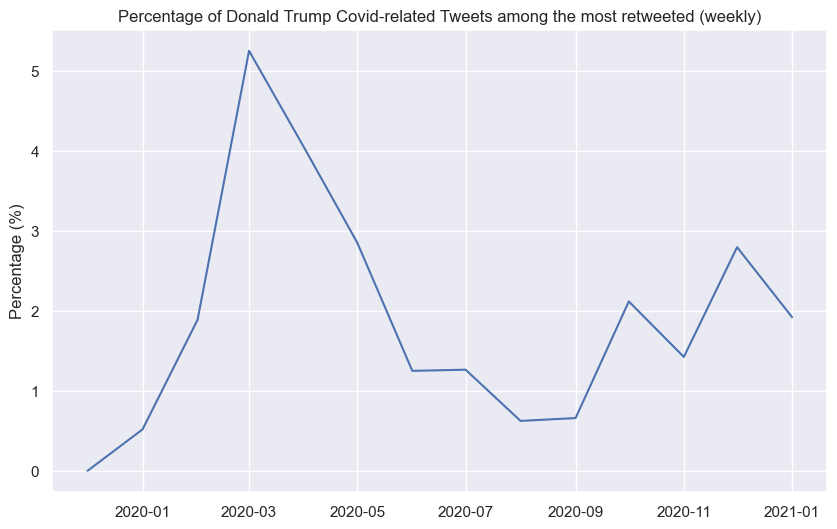

In [19]:
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: 
                                                                    ((x.covid_related)*((x.decile_retweeted==9)|(x.decile_retweeted==8)|(x.decile_retweeted==7)|
                                                                                        (x.decile_retweeted==6)|(x.decile_retweeted==5))).sum() 
                                                                                        / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

plt.figure(figsize=(10, 6)) 
plt.ylabel('Percentage (%)')
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets among the most retweeted (weekly)')
plt.show()

**As we can see the moment were we had the highest share of covid related tweets (March 2020) is also the moment we had also the highest number of tweets related to covid.**

# Causal Impact Analysis

In one of our analysis, we are interested in finding a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine on Wikipedia. During COVID-19 period Trump claimed that Hydroxychloroquine was a cure for COVID-19, this claim was not supported by scientific evidence. 

Initially we will do a preliminary graphical analysis looking at the number of visits to the page of Hydroxychloroquine on Wikipedia. We will plot the time series and draw a red line everytime Trump tweeted about Hydroxychloroquine.

After a the preliminary analysis, we will use  the 'causalimpact' library in Python to perform a test which can tell us if there is a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine.
To run this analysis we need to build a dataframe with the following columns:
- data index: the date of the observation of our time series.
- y: the number of visits to the the page of Hydroxychloroquine (test variable).
- x: the number of visits to the page of Baricitinib, a drug that was used to treat Covid-19 and that was not mentioned by Trump(control variable).

The Causality assumptions need to be verified:
- The x is not affected by the intervention (Trump's tweets) but they are correlated to y.
- The correlation between y and x should not be affected by the intervention.

We decided to take Baricitinib as a control because it is a drug used as anti-rheumatoid and that was not mentioned by Trump. We assume that the number of visits to the page of Baricitinib is not affected by Trump's tweets but it is correlated to the number of visits to the page of Hydroxychloroquine, since both drugs are used to treat rheumatoid arthritis.

Let's see the number of tweets where Hydroxychloroquine is mentioned:

In [20]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# create a new column with the result of the analysis
new_col = analyze.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', data['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [21]:
# get the dates where trump spoke about Hydroxychloroquine
critical_data_hydro = data[data['Hydroxychloroquine'] == True]['date']
week_critical_data_hydro = (critical_data_hydro - pd.to_timedelta((critical_data_hydro.dt.dayofweek+1) % 7, unit='D')).unique()

We want to get from wikipedia and from Google Trends the number of pageviews for the article related to Hydroxychloroquine. We want to graphically inspect the variation of visits number over time and see if Trump's tweets had an impact on the number of visits.

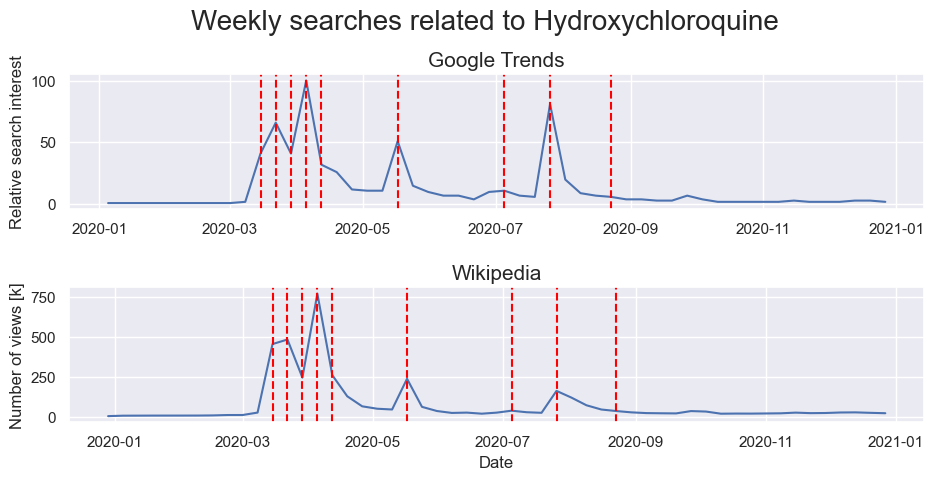

In [22]:
pagename = 'Hydroxychloroquine'
filename = 'hydroxychloroquine'

weekly_wikipedia_hydro_df, daily_wikipedia_hydro_df = load_wikipedia_df(pagename, filename)
gtrends_hydro_df = load_gtrend_df(pagename, filename)

daily_wikipedia_hydro_df = daily_wikipedia_hydro_df.drop('Week', axis=1)
daily_wikipedia_hydro_df

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_hydro_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_hydro_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]
axis[1].set_xlabel('Date')

plt.show()

As we can see the Wikipedia and Google trend pageviews behave simarly, Google Trends, uses a relative scale from 0 to 100 while Wikipedia returns the absolute number of visits. We can see that the number of visits was almost zero until march 2020. The spikes in the graph appear almost at the same time with Trump's Tweet. We should further investigate if there is a causal relationship between Trump's tweets and the number of visits. 

Let's follow the same procedure for Baricitinib:

In [23]:
ci_hydro_df = daily_wikipedia_hydro_df.copy()
ci_hydro_df = ci_hydro_df.rename(columns = {'Views' :'y'})
stop_date_hydro = week_critical_data_hydro[0]
print('First time Trump talked about Hydroxychloroquine: ', stop_date_hydro)

pagename = 'Baricitinib'
filename = 'baricitinib'

weekly_wikipedia_baricitinib_df, daily_wikipedia_baricitinib_df = load_wikipedia_df(pagename, filename)
gtrends_baricitinib_df = load_gtrend_df(pagename, filename)

daily_wikipedia_baricitinib_df = daily_wikipedia_baricitinib_df.drop('Week', axis=1)


ci_hydro_df['x'] = daily_wikipedia_baricitinib_df

First time Trump talked about Hydroxychloroquine:  2020-03-15 00:00:00


To perform the test check if the hypothesis for causal impact analysis are satisfied:

In [24]:
ci_hydro_df[:stop_date_hydro].corr()

,y,x
y,1.000000,0.575105
x,0.575105,1.000000


In [25]:
ci_hydro_df[stop_date_hydro:week_critical_data_hydro[-1]].corr()

,y,x
y,1.000000,0.176224
x,0.176224,1.000000


The correlation between y and x should not be affected by the intervention, we see that is not the case, however the change is not dramatic, we can proceed assuming that the correlation is 'reasonably' stable.

In [26]:
critical_data_hydro = pd.to_datetime(critical_data_hydro)

In [27]:
pre_period = [ci_hydro_df.index[0], critical_data_hydro.iloc[0]]
post_period = [critical_data_hydro.iloc[1], critical_data_hydro.iloc[-1]]
print(pre_period, post_period)

[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-03-21 00:00:00')] [Timestamp('2020-03-24 00:00:00'), Timestamp('2020-08-24 00:00:00')]


Now we can run the causal impact analysis:

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10477D+00    |proj g|=  5.77358D-01

At iterate    5    f=  8.88647D-01    |proj g|=  5.20151D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   1.190D-06   8.886D-01
  F =  0.88864662788843563     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
/Users/Etienne/opt/miniconda3/envs/ada/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


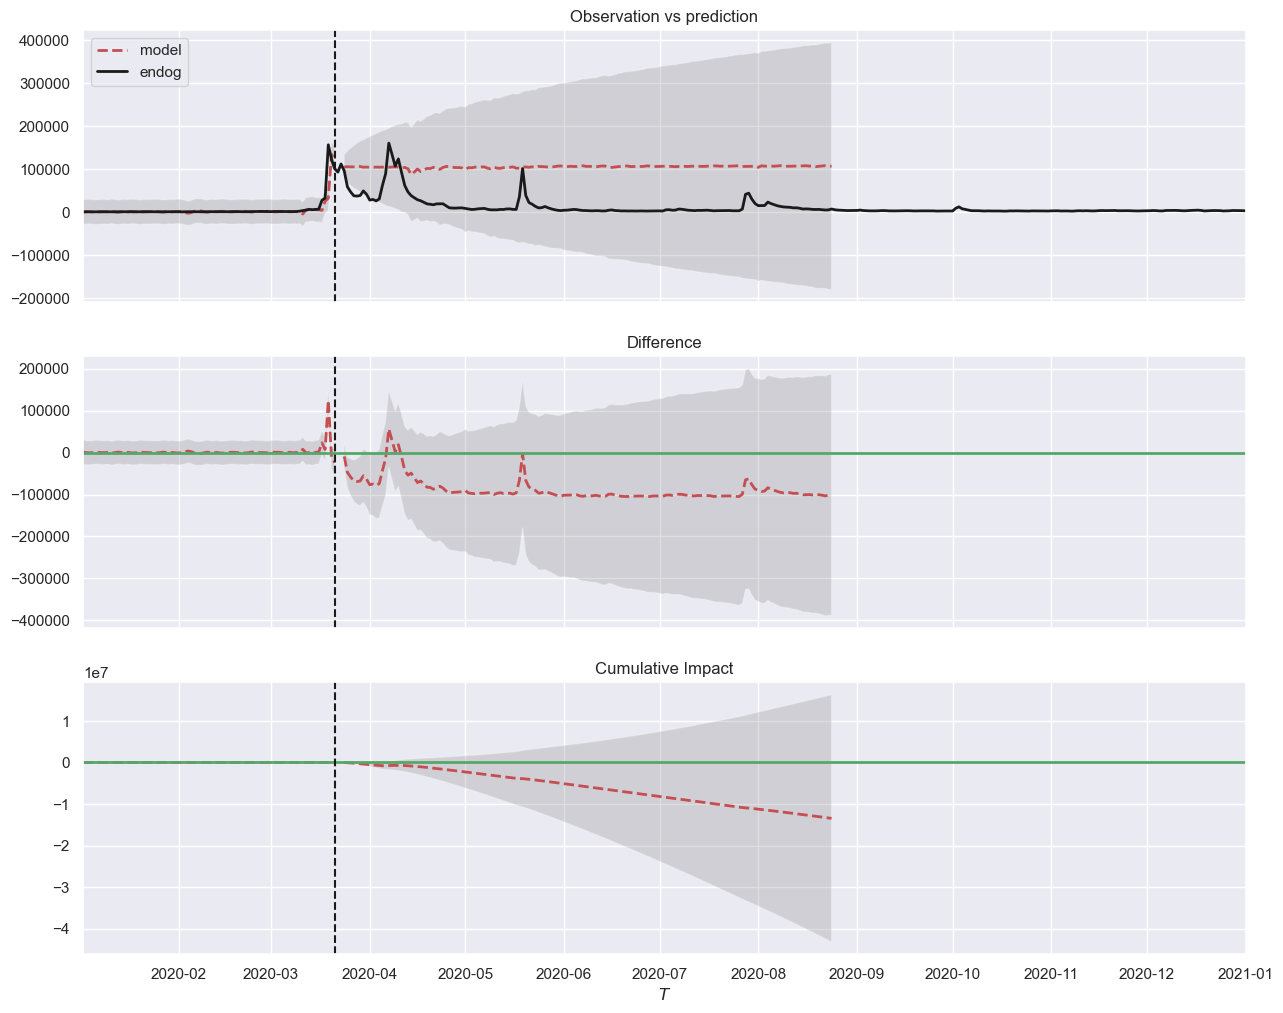

In [28]:
impact = CausalImpact(data = ci_hydro_df, pre_period=pre_period, post_period=post_period)
impact.run()
impact.plot()

In [29]:
print(impact.summary())

                                  Average             Cumulative
Actual                              17862                2750764
Predicted                          105288               16214415
95% CI                   [-87925, 298501]  [-13540456, 45969287]
                                                                
Absolute Effect                    -87426              -13463651
95% CI                  [105787, -280639]  [16291220, -43218523]
                                                                
Relative Effect                    -83.0%                 -83.0%
95% CI                  [100.5%, -266.5%]      [100.5%, -266.5%]
                                                                
P-value                             14.3%                       
Prob. of Causal Effect              85.7%                       
None


Looking at the graph it seems that immediately after the intervention the number of visits to the page of Hydroxychloroquine increased, however the confidence intervals are very wide and we cannot conclude that there is a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine. This graph could suggest us that the analysis we want to undertake cuold be unfruitful. During Milestone 3 we cuold try to find a better control variable and see if we can find a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine, or enlarge the analysis to other fake news.

Hydroxychloroquine  was not the only misinformation spread by Trump. We want to repeat the same preliminar analysis for other fake news.

### 1)  Swine Flu

Trump was tweeting a lot about Swine Flu to attack the democrats, one can study if he was resurging a trend:

Number of tweets talking about Swine Flu is:  26


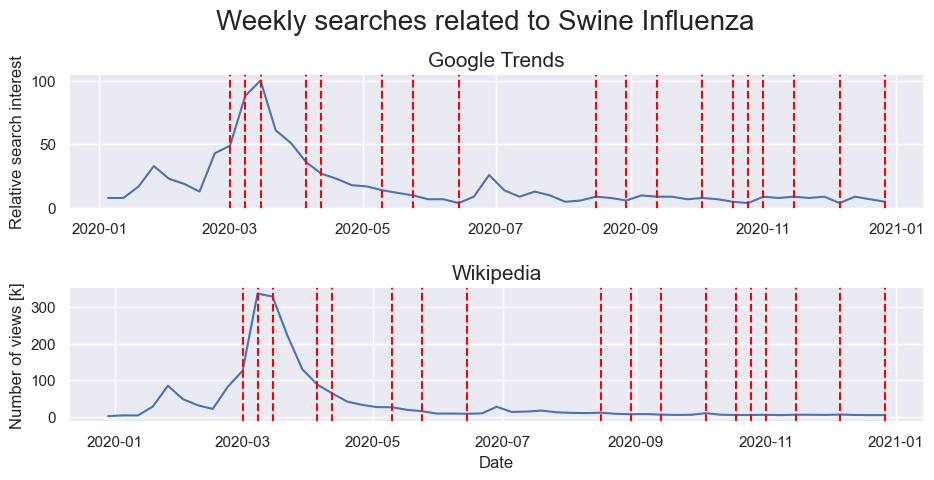

In [30]:
fake_news_swineflu = ['Swine', 'swine', 'H1N1', 'h1n1']
analyze_swineflu = data['text'].apply(lambda x: True if any(word in x for word in fake_news_swineflu) else False)

# create a new column with the result of the analysis
new_col = analyze_swineflu.reindex(data.index, fill_value=False)
data['Swineflu'] = new_col
print('Number of tweets talking about Swine Flu is: ', data['Swineflu'].sum())

# get the dates where trump spoke
critical_data = data[data['Swineflu'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'Swine Influenza'
filename = 'swineflu'

weekly_wikipedia_df, _ = load_wikipedia_df(pagename, filename)
gtrends_df = load_gtrend_df(pagename, filename)

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]
axis[1].set_xlabel('Date')

plt.show()

### 2)  China Laboratory-Leak Virus

Trump was not tweeting directly about the fact that covid escaped from a lab, however, he tweeted a lot about the "China Virus", did this feed the trend?

Number of tweets talking about COVID-19 lab leak theory is:  44


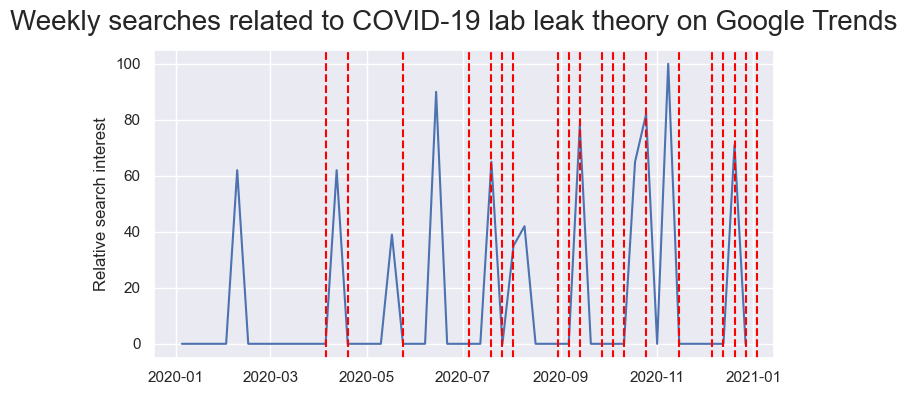

In [31]:
fake_news_leaktheory = ['China virus', 'china virus', 'chinavirus', 'Chinavirus', 'China Virus']
analyze_leaktheory = data['text'].apply(lambda x: True if any(word in x for word in fake_news_leaktheory) else False)

# create a new column with the result of the analysis
new_col = analyze_leaktheory.reindex(data.index, fill_value=False)
data['Leaktheory'] = new_col
print('Number of tweets talking about COVID-19 lab leak theory is: ', data['Leaktheory'].sum())

# get the dates where trump spoke
critical_data = data[data['Leaktheory'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'COVID-19 lab leak theory'
filename = 'leaktheory'

weekly_wikipedia_df, _ = load_wikipedia_df(pagename, filename)
gtrends_df = load_gtrend_df(pagename, filename)

plt.figure(figsize=(8, 4)) 

plt.suptitle('Weekly searches related to {pagename} on Google Trends'.format(pagename=pagename), size=20)

plt.ylabel('Relative search interest')
plt.plot(gtrends_df['Views'])
[plt.axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

plt.show()

### Granger causality test

In [32]:
# Put the tweets in a format compatible with Granger causality analysis (i.e. time series)
tweets_hydro_timeseries_df = pd.DataFrame(index=gtrends_hydro_df['Views'].index, columns=['Date'])

for date in week_critical_data_hydro:
    tweets_hydro_timeseries_df[date] = (tweets_hydro_timeseries_df.index == date).astype(int)

tweets_hydro_timeseries_df['Date'].fillna(0, inplace=True)
tweets_hydro_timeseries_df['Tweet'] = tweets_hydro_timeseries_df.iloc[:, 1:].sum(axis=1)

# Combine gtrends and tweets
gtrends_tweets_hydro_df = gtrends_hydro_df.copy()
gtrends_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']

# Combine wiki and tweets
wiki_tweets_hydro_df = weekly_wikipedia_hydro_df.copy()
wiki_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']
wiki_tweets_hydro_df['Tweets'].fillna(0, inplace=True)

In [33]:
# Granger test between Wikipedia pageviews and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

print("DO VIEWS CAUSE TWEETS?")
grangercausalitytests(wiki_tweets_hydro_df, 2)

print('\n \n --------------------------------')
print("\n \n DO TWEETS CAUSE VIEWS?")
grangercausalitytests(wiki_tweets_hydro_df[['Tweets', 'Views']], 2)

DO VIEWS CAUSE TWEETS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1650  , p=0.1476  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=2.2976  , p=0.1296  , df=1
likelihood ratio test: chi2=2.2483  , p=0.1338  , df=1
parameter F test:         F=2.1650  , p=0.1476  , df_denom=49, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7117  , p=0.4961  , df_denom=46, df_num=2
ssr based chi2 test:   chi2=1.5782  , p=0.4543  , df=2
likelihood ratio test: chi2=1.5542  , p=0.4597  , df=2
parameter F test:         F=0.7117  , p=0.4961  , df_denom=46, df_num=2

 
 --------------------------------

 
 DO TWEETS CAUSE VIEWS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.6313 , p=0.0013  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=12.3434 , p=0.0004  , df=1
likelihood ratio test: chi2=11.0755 , p=0.0009  , df=1
parameter F test:         F=11.6313 , p=0.0013  , df_denom=49, df_num=1

Granger Caus

{1: ({'ssr_ftest': (11.631288358277965, 0.0013070876024252479, 49.0, 1),
   'ssr_chi2test': (12.343408053682738, 0.0004425463688069077, 1),
   'lrtest': (11.075520105794098, 0.0008747488060236576, 1),
   'params_ftest': (11.63128835827797, 0.0013070876024252431, 49.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (5.694776885053332, 0.006169850294896658, 46.0, 2),
   'ssr_chi2test': (12.627548745118258, 0.001811184237912731, 2),
   'lrtest': (11.282265910526192, 0.0035488454446095303, 2),
   'params_ftest': (5.694776884915644, 0.0061698502955775695, 46.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

___
## Part 2: Causal Impact Analyis of Alternative Hypotheses
We studied how Trump's tweet can affect the public debate. This part proposes to perform a causal impact analysis on alternative hypothesis. To do so, we'll study the effect of discrete event on our topics (mobility changepoints and publec events in the US) and use the total trafic on Wikipedia as a time serie baseline.

The following part is reusing code and helper functions from the work [Sudden Attention Shifts on Wikipedia During the COVID-19 Crisis](https://github.com/epfl-dlab/wiki_pageviews_covid)

In [34]:
params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False
}

mpl.rcParams.update(params)

In [35]:
interventions = load_interventions("wiki_pageviews_covid/data/interventions.csv")
topics_df, topics = load_topics('wiki_pageviews_covid/data/topics_linked.csv.xz')
agg = load_aggregated("wiki_pageviews_covid/data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
dfs_pca_shift = load_pca(codes_order, pca_folder="wiki_pageviews_covid/data/pca/")

The following plot shows the evolution of pageview on wikipedia, and the amount of them related to covid. We'll superimpose the trends on Hydroxichloroquine to spot a potential correlation. Note that since the covid fighting strategies differed from a state to another, we enriched the dataset with the date of first school closure, or first lockdown in the US.

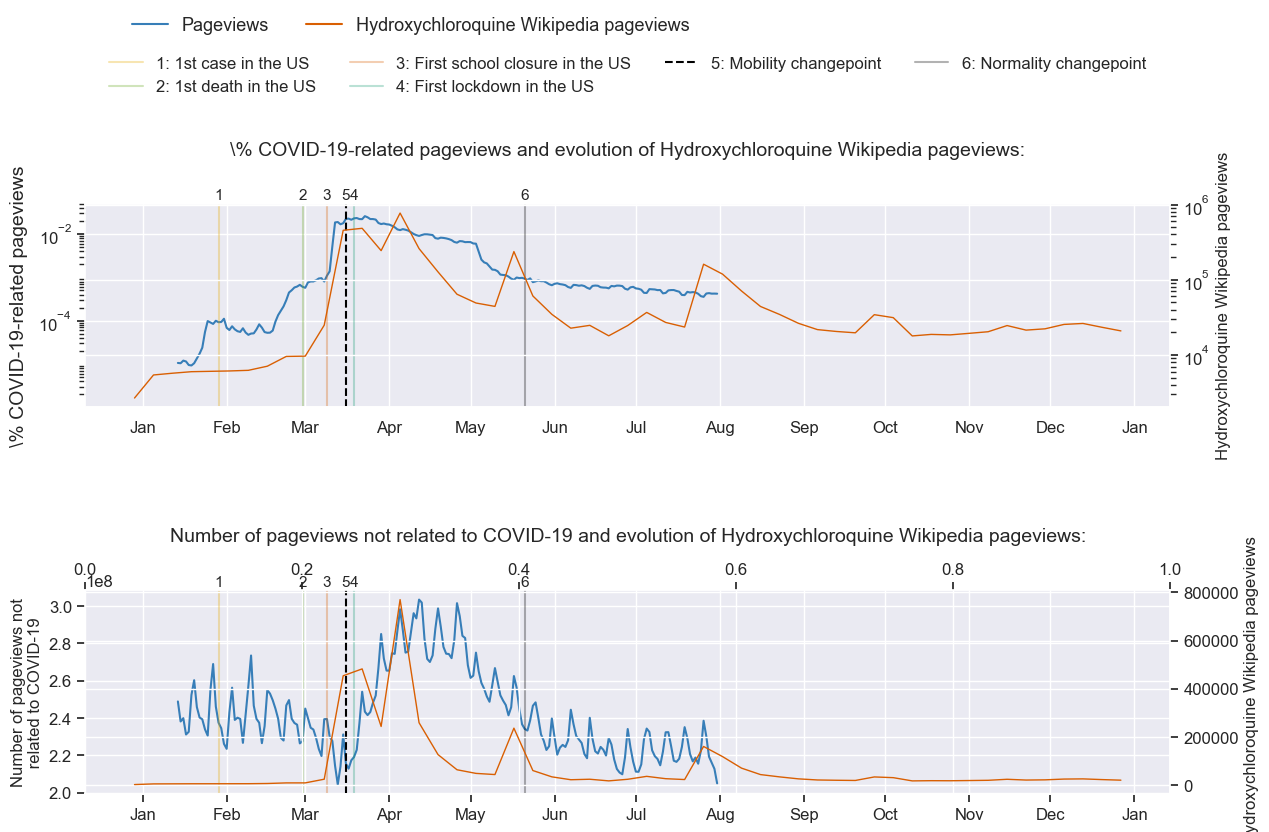

In [44]:
idx =3
fig, axs = plt.subplots(2, 1,
                       figsize=(14, 10),
                       sharex=False,
                       gridspec_kw={"hspace": 0.9, "wspace": 0.15, "top": 0.7})
# COVID-RELATED PAGEVIEWS
ax = axs[0]
code = codes_order[idx]
ax.set_ylabel(helper_langs[code], rotation=0, ha="right", va="center", fontsize=14)
start, end = plot_dates(ax, 20200114, 20200731, 
                        agg[code]["sum"].index,
                        (agg[code]["covid"]["sum"].values + agg[code + ".m"]["covid"]["sum"].values +1) 
                        / (agg[code]["sum"].values + agg[code+".m"]["sum"].values),  sci=False, color="#377eb8")

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)


ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.set_ylabel("\% COVID-19-related pageviews", rotation=90,labelpad=14.0)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.set_yscale("log")
ax.set_ylim([10**(-6), 5* 10**(-2)])
ax.set_yticks([10**(-4), 10**(-2)])

ax02 = ax.twinx() 
ax02.set_ylabel('Hydroxychloroquine Wikipedia pageviews') 
ax02.plot(weekly_wikipedia_hydro_df['Views'], color='#d95f02', linewidth=1)
ax02.set_yscale('log')
ax02.tick_params(axis ='y') 

# NON COVID-RELATED PAGEVIEWS
ax = axs[1]

ax_twin = ax.twiny()

start, end = plot_dates(ax, 20200114, 20200731, 
                    agg[code]["sum"].index, agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
                    agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values, 
                        color="#377eb8", sci=False)

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

for ax_t in [ax, ax_twin]:
    ax_t.spines['left'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    ax_t.yaxis.set_ticks_position('right')

ax.set_ylabel("Number of pageviews not\n related to COVID-19 ")

ax12 = ax.twinx() 
ax12.set_ylabel(' Hydroxychloroquine Wikipedia pageviews') 
ax12.plot(weekly_wikipedia_hydro_df['Views'], color='#d95f02', linewidth=1)
ax12.tick_params(axis ='y') 

#General labels:
axs[0].set_title("\% COVID-19-related pageviews and evolution of Hydroxychloroquine Wikipedia pageviews:",pad=35)
axs[1].set_title("Number of pageviews not related to COVID-19 and evolution of Hydroxychloroquine Wikipedia pageviews:",pad=35)

lines = [
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-"),
    Line2D([0], [0], color='#d95f02', lw=1.5, ls="-"),
    Line2D([0], [0], color="black", lw=1.5, ls=":")
]

axs[0].legend(
    handles=lines,
    labels=["Pageviews","Hydroxychloroquine Wikipedia pageviews"],
    loc='upper center', bbox_to_anchor=(0.3, 2),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=13
)
lines_interv = [Line2D([0], [0], color=int_c[x], ls=int_ls[x], alpha=0.3 if x != "Mobility" else 1.) 
                for x, _ in interventions_helper.items()]

axs[1].legend(
    handles= lines_interv,
    labels=["{}: {}".format(v, 
                            k.replace("Mobility", "Mobility changepoint")\
                            .replace("Normalcy", "Normality changepoint"))
            for k, v in interventions_helper.items()],
    loc='upper center', bbox_to_anchor=(.5,3.7),
    ncol=4, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=12
)